In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# data download
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [2]:
training_data.data.shape, training_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [3]:
test_data.data.shape, test_data.targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [4]:
# dataset
X_train = training_data.data.reshape(-1, 28*28).type(torch.FloatTensor)
y_train = training_data.targets

X_test = test_data.data.reshape(-1, 28*28).type(torch.FloatTensor)
y_test = test_data.targets

In [5]:
class MLPClassifier(nn.Module):
    def __init__(self, n_feature, num_classes, hidden_layers=[64], activation_fn='ReLU'):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential()
        activation = getattr(nn, activation_fn)

        # set hidden layer
        for i in range(len(hidden_layers)):
            if i == 0:
                self.net.append(nn.Linear(n_feature, hidden_layers[i]))
#                self.net.append(activation())
            else:
                self.net.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
#                self.net.append(activation())

        # set softmax
        self.net.append(nn.Linear(hidden_layers[-1], num_classes))
        self.net.append(nn.LogSoftmax(dim=1))


    def forward(self, x):
        return self.net(x)

    def fit(self, X, y, epochs=1000, batch_size=64, lr=0.01, optimizer='SGD', loss='BCELoss', print_every=100):
        y_hot = nn.functional.one_hot(y.flatten()).type(torch.FloatTensor)

        optimizer = getattr(torch.optim, optimizer)(self.net.parameters(), lr=lr)
        try:
            loss_fn = getattr(nn, loss)()
        except:
            loss_fn = getattr(F, loss)

        n_batch = int(len(X)/batch_size)
        for epoch in range(1, epochs+1):
            total_loss = 0
            total = 0
            for i in range(1, n_batch+1):
                X_batch = X[i*batch_size:i*batch_size+batch_size]
                y_batch = y_hot[i*batch_size:i*batch_size+batch_size]
                if i == n_batch:
                    X_batch = X[i*batch_size:-1]
                    y_batch = y_hot[i*batch_size:-1]

                optimizer.zero_grad()

                # forward
                pred = self.net(X_batch)
                loss = loss_fn(pred, y_batch)
                total_loss += loss.item()

                # check accuracy
                correct = sum(torch.argmax(pred, dim=1) == torch.argmax(y_batch, dim=1))
                total += correct

                # backward
                loss.backward()
                optimizer.step()
                print(f'Epoch [{epoch}/{epochs}]: [{i*batch_size}/{len(X)}], Loss: {loss:.4f}, Accuracy: {correct/len(y_batch) * 100:.2f}', end='\r')
            total_loss = total_loss / n_batch
            print(f"Epoch [{epoch}/{epochs}]: [{len(X)}/{len(X)}], Loss: {total_loss:.4f}, Accuracy: {total/len(y)*100:.2f}")

    def predict(self, X):
        return torch.argmax(self.net(X), axis=1)

In [6]:
mnist_model = MLPClassifier(28*28, 10, hidden_layers=[512, 256, 128])
mnist_model

MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [7]:
mnist_model.fit(X_train, y_train, epochs=10, batch_size=512, lr=1e-5, optimizer='Adam', loss='CrossEntropyLoss')

Epoch [1/10]: [60000/60000], Loss: 3.2920, Accuracy: 52.60
Epoch [2/10]: [60000/60000], Loss: 1.0085, Accuracy: 77.71
Epoch [3/10]: [60000/60000], Loss: 0.7356, Accuracy: 82.53
Epoch [4/10]: [60000/60000], Loss: 0.6103, Accuracy: 84.75
Epoch [5/10]: [60000/60000], Loss: 0.5365, Accuracy: 86.10
Epoch [6/10]: [60000/60000], Loss: 0.4869, Accuracy: 87.06
Epoch [7/10]: [60000/60000], Loss: 0.4509, Accuracy: 87.74
Epoch [8/10]: [60000/60000], Loss: 0.4234, Accuracy: 88.37
Epoch [9/10]: [60000/60000], Loss: 0.4018, Accuracy: 88.84
Epoch [10/10]: [60000/60000], Loss: 0.3842, Accuracy: 89.20


In [8]:
sum(mnist_model.predict(X_train) == y_train)/60000 *100

tensor(90.2767)

In [9]:
sum(mnist_model.predict(X_test) == y_test)/60000 *100

tensor(14.9667)

In [28]:
class CNNClassifier(nn.Module):
    def __init__(self, n_feature, num_classes, hidden_layers=[128], activation_fn='ReLU'):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential()
        activation = getattr(nn, activation_fn)
        
        # 2D CNN layer
        self.net.append(nn.Conv2d(1,32, 3, 1))
        self.net.append(nn.ReLU())
        self.net.append(nn.Conv2d(32, 64, 3, 1))
        self.net.append(nn.ReLU())
        self.net.append(nn.MaxPool2d(2))
#        self.net.append(nn.Dropout(0.25))

        # fc layer
        self.net.append(nn.Flatten())
        for i in range(len(hidden_layers)):
            if i == 0:
                self.net.append(nn.Linear(9216, hidden_layers[i]))
                self.net.append(activation())
#                self.net.append(nn.Dropout(0.5))
            else:
                self.net.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
                self.net.append(activation())

        # set softmax
        self.net.append(nn.Linear(hidden_layers[-1], num_classes))
        self.net.append(nn.LogSoftmax(dim=1))


    def forward(self, x):
        return self.net(x)

    def fit(self, X, y, epochs=1000, batch_size=64, lr=0.01, optimizer='SGD', loss='BCELoss', print_every=100):
        y_hot = nn.functional.one_hot(y.flatten()).type(torch.FloatTensor)

        optimizer = getattr(torch.optim, optimizer)(self.net.parameters(), lr=lr)
        try:
            loss_fn = getattr(nn, loss)()
        except:
            loss_fn = getattr(F, loss)

        n_batch = int(len(X)/batch_size)
        for epoch in range(1, epochs+1):
            total_loss = 0
            total = 0
            for i in range(1, n_batch+1):
                X_batch = X[i*batch_size:i*batch_size+batch_size]
                y_batch = y_hot[i*batch_size:i*batch_size+batch_size]
                if i == n_batch:
                    X_batch = X[i*batch_size:-1]
                    y_batch = y_hot[i*batch_size:-1]

                optimizer.zero_grad()

                # forward
                pred = self.net(X_batch)
                loss = loss_fn(pred, y_batch)
                total_loss += loss.item()

                # check accuracy
                correct = sum(torch.argmax(pred, dim=1) == torch.argmax(y_batch, dim=1))
                total += correct

                # backward
                loss.backward()
                optimizer.step()
                print(f'Epoch [{epoch}/{epochs}]: [{i*batch_size}/{len(X)}], Loss: {loss:.4f}, Accuracy: {correct/len(y_batch) * 100:.2f}', end='\r')
            total_loss = total_loss / n_batch
            print(f"Epoch [{epoch}/{epochs}]: [{len(X)}/{len(X)}], Loss: {total_loss:.4f}, Accuracy: {total/len(y)*100:.2f}")

    def predict(self, X, batch_size=64):
        n_num = int(len(X)/batch_size)+1
        result = torch.argmax(self.net(X[0:batch_size]), axis=1)
        for i in range(1, n_num):
            if i == n_num:
                result = torch.concat([result, torch.argmax(self.net(X[i*batch_size:-1]), axis=1)],axis=0)
                return result
            result = torch.concat([result, torch.argmax(self.net(X[i*batch_size:i*batch_size+batch_size]), axis=1)],axis=0)
        return result

In [29]:
cnn_model = CNNClassifier(28*28, 10, hidden_layers=[128])
cnn_model.fit(X_train.reshape(-1,1, 28, 28), y_train, epochs=1, batch_size=512, lr=1e-3, optimizer='Adam', loss='CrossEntropyLoss')

Epoch [1/1]: [60000/60000], Loss: 1.7229, Accuracy: 85.19


In [31]:
sum(cnn_model.predict(X_train.reshape(-1,1, 28, 28), batch_size=512) == y_train)/60000 *100, sum(cnn_model.predict(X_test.reshape(-1,1, 28, 28), batch_size=512) == y_test)/10000 *100

(tensor(97.6150), tensor(97.5300))

In [89]:
for layer in cnn_model.net.modules():
    if type(layer) == nn.Sequential:
        continue
    print(layer)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU()
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=9216, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=10, bias=True)
LogSoftmax(dim=1)


In [115]:
def get_layer_ouput(X, layer_number, model=None):
    if model is None:
        return
    result = None
    for i, layer in enumerate(model.net.modules()):
        if i == 0:
            continue
        print(i, layer)
        if i == 1:
            result = layer(X)
            continue
        result = layer(result)
        if i == layer_number:
            return result
    return

In [132]:
first_cnn_layer = get_layer_ouput(training_data.data[:5].reshape(-1,1, 28, 28).type(torch.FloatTensor), 2, model=cnn_model)
forth_cnn_layer = get_layer_ouput(training_data.data[:5].reshape(-1,1, 28, 28).type(torch.FloatTensor), 4, model=cnn_model)
first_cnn_layer.shape

1 Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
2 ReLU()
1 Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
2 ReLU()
3 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
4 ReLU()


torch.Size([5, 32, 26, 26])

In [128]:
def plot_img(X, col=2):
    from matplotlib import pyplot as plt
    row = int(len(X)/col)+1 if type(len(X)/col) == float else int(len(X)/col)
    fig, axes = plt.subplots(row, col)

    for i, x in enumerate(X.reshape(-1, X.shape[-1],X.shape[-1])):
        axes[int(i/col)][i%col].imshow(x, cmap='grey')
    plt.show()

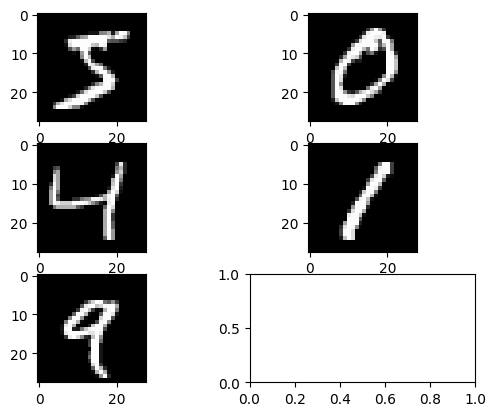

In [129]:
plot_img(training_data.data[:5])

In [130]:
training_data.data[:3].shape

torch.Size([3, 28, 28])

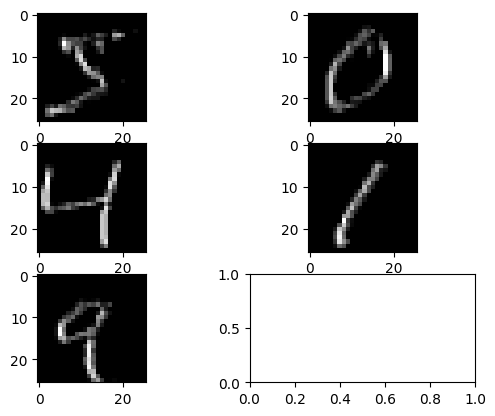

In [131]:
plot_img(first_cnn_layer.detach().numpy()[:, :1, :])

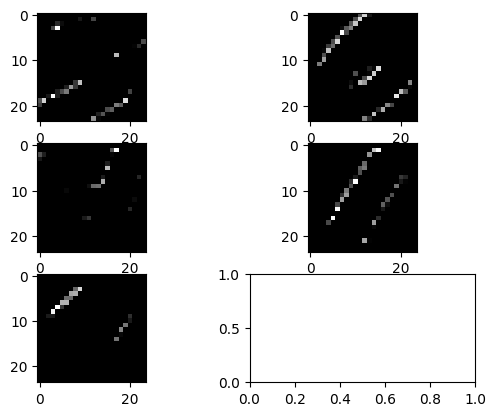

In [133]:
plot_img(forth_cnn_layer.detach().numpy()[:, :1, :])

In [185]:
# Image color : 3 Chennels -> RGB
# Image color : 4 Chennels -> CMYK


from torchvision.io import read_image
img = read_image('XOR example.png')

In [181]:
img = torch.concat([img[0].reshape(808, 1116, 1), img[1].reshape(808, 1116, 1), img[2].reshape(808, 1116, 1), img[3].reshape(808, 1116, 1)], axis=2)

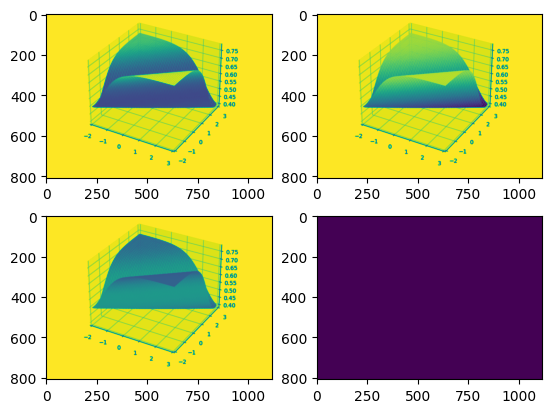

In [183]:
row, col = 2, 2
fig, axes = plt.subplots(row, col)
axes[0, 0].imshow(img[:, :, 0])
axes[0, 1].imshow(img[:, :, 1])
axes[1, 0].imshow(img[:, :, 2])
axes[1, 1].imshow(img[:, :, 3])

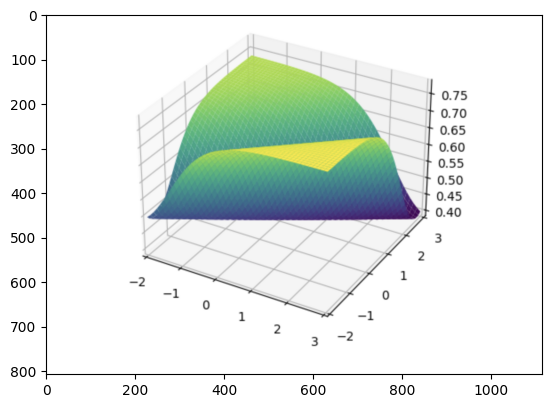

In [184]:
plt.imshow(img)